In [425]:
import numpy as np
import numpy.random as rando
import math
import pandas as pd
import os
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats


In [426]:
def read_file(file_name):
    file_path = os.path.join(file_name)
    print(file_path)
    print(os.getcwd())
    df = pd.read_csv(file_name,delimiter=",",names=["accX","accY","accZ","gyroX","gyroY","gyroZ","alt","temp"],header=None)
    return df
df = read_file("7minsrestingaccel_gyro.txt")
data = df[["accX","accY","accZ","gyroX","gyroY","gyroZ"]]

7minsrestingaccel_gyro.txt
/home/theurerjohn3


In [427]:
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [428]:
def gyrotoeuler(gyro,pos,dt):
    sinPhi = math.sin(pos[0])
    cosPhi = math.cos(pos[0])
    cosTheta = math.cos(pos[1])
    tanTheta = math.tan(pos[1])
    
    d= np.matrix([
        [1,math.sin(pos[0])*math.tan(pos[1]),math.cos(pos[0])*math.tan(pos[1])],
        [0,math.cos(pos[0]),-math.sin(pos[0])],
        [0,math.sin(pos[0])/math.cos(pos[1]),math.cos(pos[0])/math.cos(pos[1])]
    ])
    cat = d*np.matrix(gyro).T
    
    return np.matrix(cat)
    

In [429]:
plt.gcf().clear()

cum_rot = np.matrix(
[[ 1,  0, 0],
 [0, 1, 0],
 [0, 0, 1]]
)
cum_vel = np.matrix([
    [0],
    [0],
    [0]
])
cum_pos = np.matrix([
    [0],
    [0],
    [0]
])
inital_g= np.matrix([np.mean(data.loc[1:20]["accX"]),np.mean(data.loc[1:20]["accY"]),np.mean(data.loc[1:20]["accZ"])])

delta_t = 0.1
x_acc_coll = []
y_acc_coll = []
z_acc_coll = []
det_collection = []
tot_acc_coll = []
samp = 1200
start = 1
firsty =[]
lasty = []


yeah =[]
for k in range(start,samp):
    g_norm = [[data.loc[k]["accX"]],[data.loc[k]["accY"]],[data.loc[k]["accZ"]]]
    for i in range(0,3):
        g_norm[i]= g_norm[i][0]
        
    g_norm = np.matrix(g_norm)
    
    holder = [data.loc[k]["gyroX"],data.loc[k]["gyroY"],data.loc[k]["gyroZ"]]
    for i in range(0,3):
        if abs(holder[i]) <0.5:
            holder[i]=0
        else:
            print("hi")
    yeah.append(holder[2])
    
        
    holder = gyrotoeuler(holder,rotationMatrixToEulerAngles(cum_rot),delta_t).T
    z_rot = np.matrix([
        [ math.cos(math.radians(holder.item(2))) , -math.sin(math.radians(holder.item(2))) ,  0 ],
        [ math.sin(math.radians(holder.item(2))) , math.cos(math.radians(holder.item(2)))  , 0 ],
        [ 0 , 0 , 1 ]
    ])
    y_rot = np.matrix([
        [ math.cos(math.radians(holder.item(1)))  , 0 , math.sin(math.radians(holder.item(1))) ],
        [ 0 , 1 , 0 ],
        [ -math.sin(math.radians(holder.item(1))) ,  0 , math.cos(math.radians(holder.item(1))) ]
    ])
    x_rot = np.matrix([
        [ 1 , 0 , 0 ],
        [ 0 , math.cos(math.radians(holder.item(0))) , -math.sin(math.radians(holder.item(0))) ],
        [ 0 , math.sin(math.radians(holder.item(0))) , math.cos(math.radians(holder.item(0))) ]
        
    ])
    total_rot = z_rot*y_rot*x_rot
    cum_rot = cum_rot *total_rot
    firsty.append(cum_rot.item(0,1))
    inertal_acc = cum_rot*g_norm.T
    inertal_acc = inertal_acc - inital_g.T
    #for i in range(0,3):
    #    if abs(inertal_acc[i])<2:
    #        inertal_acc[i]=0
    x_acc_coll.append(inertal_acc.item(0))
    y_acc_coll.append(inertal_acc.item(1))
    z_acc_coll.append(inertal_acc.item(2))
    tot_acc_coll.append(math.sqrt(inertal_acc[0]*inertal_acc[0]+inertal_acc[1]*inertal_acc[1]+inertal_acc[2]*inertal_acc[2]))
    vel = inertal_acc*delta_t
    cum_vel = cum_vel+vel
    cum_pos = cum_pos + cum_vel*delta_t
    
    det_collection.append(np.linalg.det(cum_rot))
print(cum_pos)

[[ -36.2412]
 [-164.839 ]
 [   3.293 ]]


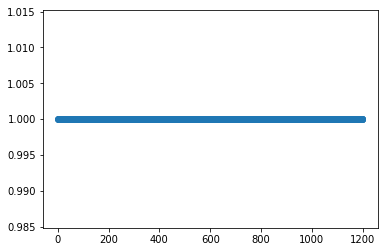

In [430]:
plt.scatter(range(start,samp),det_collection)
plt.show()

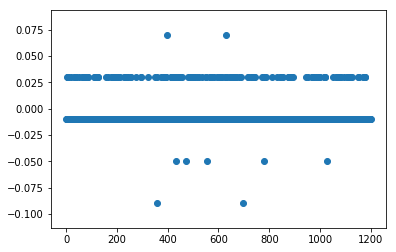

-0.00529608006672227

In [431]:
plt.scatter(range(start,samp),x_acc_coll)
plt.show()
np.mean(x_acc_coll)

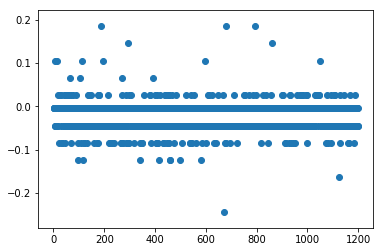

-0.023382402001668016

In [432]:
plt.scatter(range(start,samp),y_acc_coll)
plt.show()
np.mean(y_acc_coll)

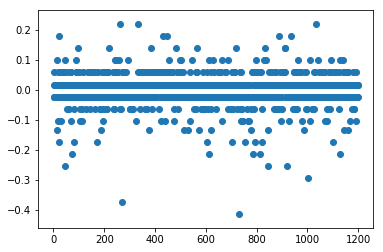

-0.00018140116763917327

In [433]:
plt.scatter(range(start,samp),z_acc_coll)
plt.show()
np.mean(z_acc_coll)

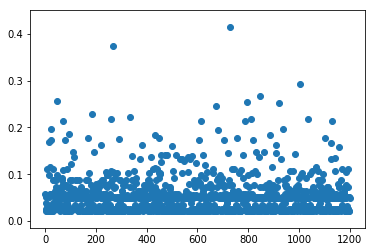

In [434]:
plt.scatter(range(start,samp),tot_acc_coll)
plt.show()

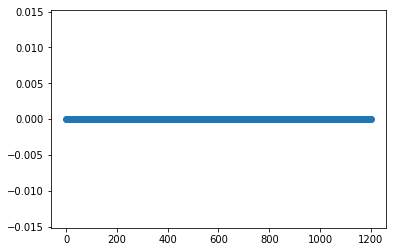

In [435]:
plt.scatter(range(start,samp),firsty)
plt.show()

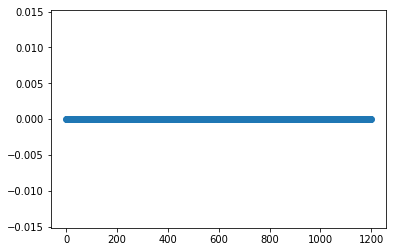

0.0


In [436]:
plt.scatter(range(0,len(yeah)),yeah)
plt.show()
print(np.mean(yeah))

In [437]:

aardvark = z_acc_coll[600:1200]
print(np.std(aardvark))
print(np.mean(aardvark))
thingie = np.mean(aardvark)


0.0549517823582
-0.00253338898164


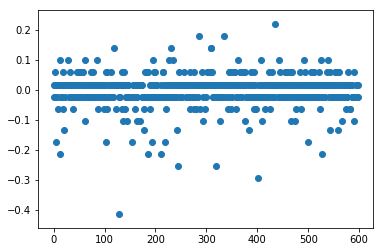

In [438]:
plt.scatter(range(0,len(aardvark)),aardvark)
plt.show()

In [439]:
for i in range(0,len(aardvark)):
    aardvark[i]=aardvark[i]-thingie

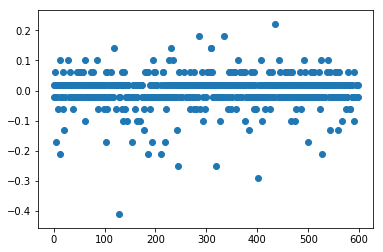

In [440]:
plt.scatter(range(0,len(aardvark)),aardvark)
plt.show()


In [441]:
from scipy import stats
import matplotlib.pyplot as plt

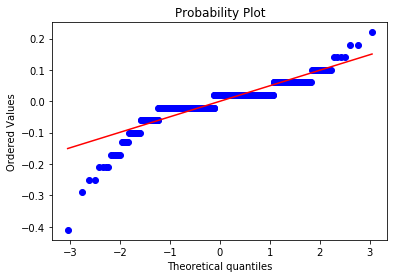

In [442]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(aardvark, plot=ax)
plt.show()

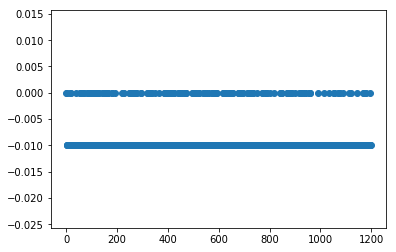

-0.008682235196


In [443]:
cat = []
for i in data[1:1200]["gyroZ"]:
    cat.append(i)
plt.scatter(range(0,len(cat)),cat)
plt.show()
print(np.mean(cat))

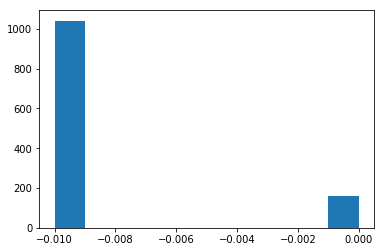

In [444]:
plt.hist(cat)
plt.show()